# Assignment 2: CoinPilot user segmentation, modelling, and lightweight deployment

## Business issues to address
1. User segmentation challenge  
2. Premium conversion prediction  
3. Portfolio and engagement patterns  
4. Operationalisation via lightweight deployment  

---

## 0) Setup cell to install packages

In [1]:
# Install required libraries
# Run this cell once at the start
!pip install numpy pandas scikit-learn xgboost matplotlib fastapi "pydantic<2" uvicorn streamlit joblib requests

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ------ --------------------------------- 9.2/56.8 MB 43.9 MB/s eta 0:00:02
   ------------ --------------------------- 17.6/56.8 MB 41.0 MB/s eta 0:00:01
   ------------------ --------------------- 26.7/56.8 MB 42.4 MB/s eta 0:00:01
   ------------------------- -------------- 36.7/56.8 MB 43.2 MB/s eta 0:00:01
   -------------------------------- ------- 45.6/56.8 MB 43.3 MB/s eta 0:00:01
   -------------------------------------- - 55.3/56.8 MB 44.0 MB/s eta 0:00:01
   ---------------------------------------- 56.8/56.8 MB 40.2 MB/s eta 0:00:00


## 1) Data preparation and sanity checks
### Your tasks in this section:
- Load the dataset into a Pandas DataFrame.
- Display descriptive statistics and feature distributions.
- Calculate and display the premium conversion rate overall and by `country`.
- Produce at least one simple chart (e.g., bar chart of conversion rate by `country`).


In [3]:
# Load dataset here
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

coinpilot_data = pd.read_csv("coinpilot_data.csv")

Dataset Basic Information:
Data shape: (100000, 17)
Column names: ['age', 'tenure_months', 'income_monthly', 'savings_rate', 'risk_score', 'app_opens_7d', 'sessions_7d', 'avg_session_min', 'alerts_opt_in', 'auto_invest', 'country', 'equity_pct', 'bond_pct', 'cash_pct', 'crypto_pct', 'converted_premium', 'portfolio_total']

Data types:
age                    int64
tenure_months          int64
income_monthly       float64
savings_rate         float64
risk_score           float64
app_opens_7d           int64
sessions_7d            int64
avg_session_min      float64
alerts_opt_in          int64
auto_invest            int64
country               object
equity_pct           float64
bond_pct             float64
cash_pct             float64
crypto_pct           float64
converted_premium      int64
portfolio_total      float64
dtype: object

Descriptive Statistics:
                 age  tenure_months  income_monthly   savings_rate  \
count  100000.000000  100000.000000   100000.000000  100000.0

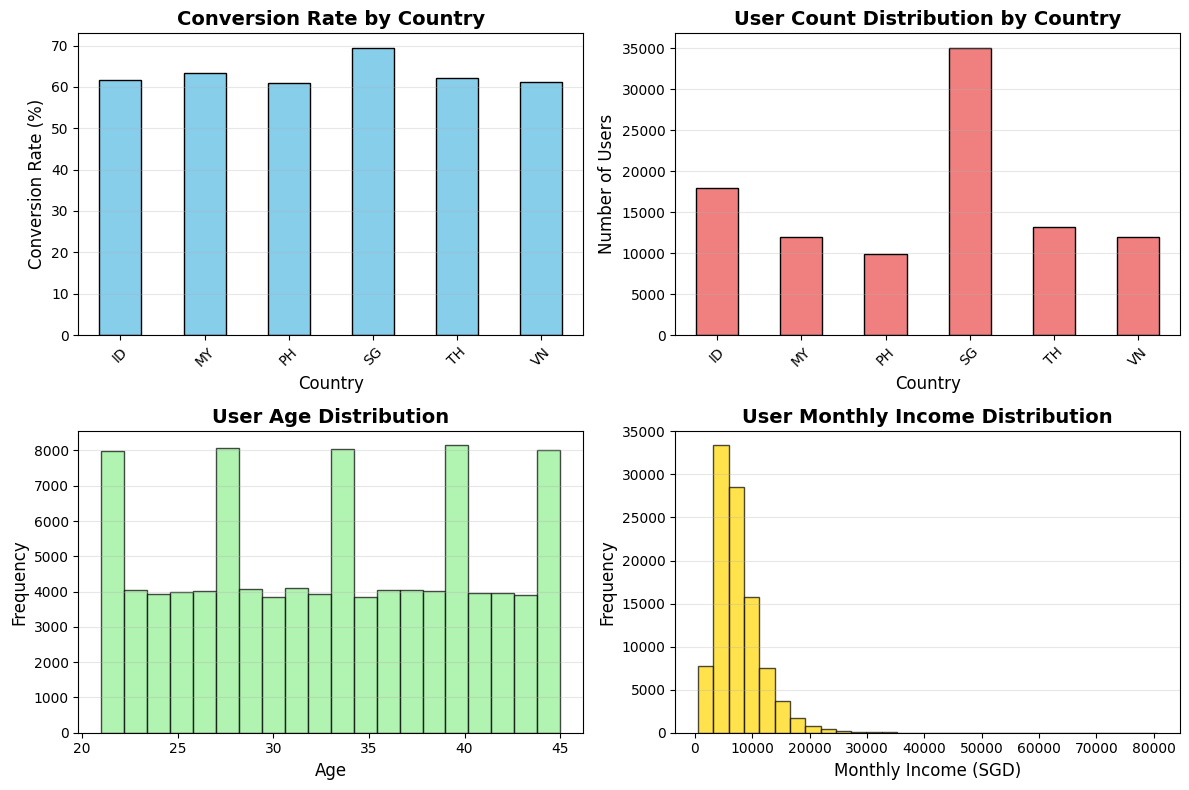


Portfolio Allocation Analysis:
          equity_pct       bond_pct       cash_pct     crypto_pct
count  100000.000000  100000.000000  100000.000000  100000.000000
mean       35.778519      19.511612      21.367532      23.342336
std        18.834470      15.750504      16.160443      16.575822
min         0.097401       0.000156       0.000189       0.000657
25%        21.026558       6.994775       8.502074      10.087341
50%        33.985635      15.680385      17.775533      20.085634
75%        48.860576      28.336360      30.877812      33.517209
max        97.600940      93.524190      94.576326      93.770060

Portfolio Percentage Total Statistics:
Mean: 100.00%
Standard deviation: 0.00%
Minimum: 100.00%
Maximum: 100.00%


In [ ]:
# Display descriptive statistics
print("Dataset Basic Information:")
print(f"Data shape: {coinpilot_data.shape}")
print(f"Column names: {list(coinpilot_data.columns)}")
print("\nData types:")
print(coinpilot_data.dtypes)
print("\nDescriptive Statistics:")
print(coinpilot_data.describe())

# Check for missing values
print("\nMissing Values Check:")
print(coinpilot_data.isnull().sum())

# Display feature distributions for key variables
print("\nKey Feature Distributions:")
print(f"Age range: {coinpilot_data['age'].min()} - {coinpilot_data['age'].max()}")
print(f"Tenure range: {coinpilot_data['tenure_months'].min()} - {coinpilot_data['tenure_months'].max()}")
print(f"Monthly income range: {coinpilot_data['income_monthly'].min():.2f} - {coinpilot_data['income_monthly'].max():.2f}")
print(f"Risk score range: {coinpilot_data['risk_score'].min():.2f} - {coinpilot_data['risk_score'].max():.2f}")

# Conversion rate overall and by country
overall_conversion_rate = coinpilot_data['converted_premium'].mean()
print(f"\nOverall Premium Conversion Rate: {overall_conversion_rate:.4f} ({overall_conversion_rate*100:.2f}%)")

print("\nConversion Rate by Country:")
conversion_by_country = coinpilot_data.groupby('country')['converted_premium'].agg(['count', 'sum', 'mean']).round(4)
conversion_by_country.columns = ['Total Users', 'Premium Users', 'Conversion Rate']
conversion_by_country['Conversion Rate %'] = (conversion_by_country['Conversion Rate'] * 100).round(2)
print(conversion_by_country)

# Simple visualisation (e.g. bar chart)
plt.figure(figsize=(12, 8))

# Subplot 1: Conversion rate by country bar chart
plt.subplot(2, 2, 1)
conversion_by_country['Conversion Rate %'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Conversion Rate by Country', fontsize=14, fontweight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Conversion Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Subplot 2: User count distribution by country
plt.subplot(2, 2, 2)
conversion_by_country['Total Users'].plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('User Count Distribution by Country', fontsize=14, fontweight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Subplot 3: Age distribution histogram
plt.subplot(2, 2, 3)
plt.hist(coinpilot_data['age'], bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title('User Age Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Subplot 4: Monthly income distribution histogram
plt.subplot(2, 2, 4)
plt.hist(coinpilot_data['income_monthly'], bins=30, color='gold', edgecolor='black', alpha=0.7)
plt.title('User Monthly Income Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Monthly Income (SGD)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Portfolio allocation analysis
print("\nPortfolio Allocation Analysis:")
portfolio_cols = ['equity_pct', 'bond_pct', 'cash_pct', 'crypto_pct']
portfolio_stats = coinpilot_data[portfolio_cols].describe()
print(portfolio_stats)

# Check if portfolio percentages are reasonable (should be close to 100%)
coinpilot_data['portfolio_total'] = coinpilot_data[portfolio_cols].sum(axis=1)
print(f"\nPortfolio Percentage Total Statistics:")
print(f"Mean: {coinpilot_data['portfolio_total'].mean():.2f}%")
print(f"Standard deviation: {coinpilot_data['portfolio_total'].std():.2f}%")
print(f"Minimum: {coinpilot_data['portfolio_total'].min():.2f}%")
print(f"Maximum: {coinpilot_data['portfolio_total'].max():.2f}%")

## 2) Unsupervised user segmentation

### Your tasks in this section:
- Carry out PCA and produce the scree plot.
- Run t-SNE and produce a labelled scatterplot.
- Apply k-means with your chosen `k` and profile the clusters.
- Provide short markdown commentary on patterns you observe.


In [ ]:
# Scale numeric features and apply PCA


# Scree plot and cumulative explained variance




# t-SNE visualisation


# K-means clustering and cluster profiling



### Commentary
Write your observations here.




## 3) Ensemble modelling for premium conversion

### Your tasks in this section:
- Train and evaluate all three ensemble models (Random Forest, AdaBoost, XGBoost).
- Compare performance across accuracy, precision, recall, and ROC AUC.
- Include at least one feature importance visualisation.
- Add brief markdown comments on which features stand out as strong predictors.


In [ ]:
# Train-test split


# Random Forest with OOB


# AdaBoost with shallow base learner


# XGBoost classifier


# Compare metrics across models


# Feature importance visualisation(s)



### Commentary
Summarise standout features here.




## 4) Stacking and model comparison

### Your tasks in this section:
- Implement a StackingClassifier with two base models.
- Generate a results table showing all models with the same set of metrics.
- Create a comparison visualisation.
- Justify your chosen “best” model using your results.


In [ ]:
# StackingClassifier implementation


# Results table of all models


# Visual comparison (plot)




### Recommendation
Justify your chosen model here.




## 5) FastAPI prediction service and Streamlit client

### Your tasks in this section:
- Create and save the scikit-learn pipeline.
- Write and test the FastAPI endpoints.
- Develop a Streamlit client with online (API) and offline (local) prediction paths.
- Demonstrate at least one working prediction end-to-end.


In [ ]:
# Build pipeline (scaling + encoding + classifier) and save with joblib


# FastAPI app (define endpoints)


# Example code to run uvicorn server from notebook (optional)


# Streamlit client (API call + offline fallback)




## 6) Findings and recommendations

### Your tasks in this section:
- Summarise in 6–10 bullet points what your analysis uncovered:
  - Key user segments from clustering
  - Best-performing model for conversion prediction
  - Business-relevant features influencing premium conversion
  - Clear next steps for CoinPilot’s product and marketing team
- Keep findings grounded in your outputs (no speculation).


### Findings and Recommendations
- Point 1 …  
- Point 2 …  
- Point 3 …  
...




---

## Submission Guidelines

* **Due Date:** 28 Sep 2025 (Sunday), 11:59pm
* **Submission Method:** Upload single Jupyter notebook file
* **File Naming:** `name_assignment2.ipynb`
* **File Size:** Ensure notebook runs completely and all outputs are saved
* **Dependencies:** Include installation commands for all required packages in your notebook
* **Late Policy:** 10% deduction for every 24 hours late. No submission allowed beyond 48 hours late.

---
